<a href="https://colab.research.google.com/github/Namgyo/IE55201-Paper-Presentation/blob/main/augmented_neural_ode_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch

device = torch.device('cpu')

In [4]:
import os
print("Current working directory:", os.getcwd())



Current working directory: /content


In [5]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/augmented-neural-odes-master/augmented-neural-odes-master')


In [9]:
!pip install torchdiffeq

# Augmented Neural ODEs
This notebook contains example of how to train Neural ODEs and Augmented Neural ODEs and to visualize their differences. This includes differences in how they warp the input space, how they generalize and how their ODEs map inputs to features.

## Create and visualize training data

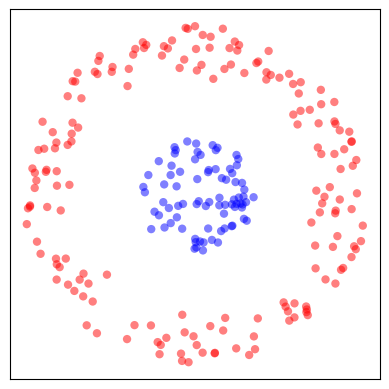

In [6]:
from experiments.dataloaders import ConcentricSphere
from torch.utils.data import DataLoader
from viz.plots import single_feature_plt

# Create training data in 2D, consisting of a concentric disk and an annulus
data_dim = 2
data_concentric = ConcentricSphere(data_dim, inner_range=(0., .5), outer_range=(1., 1.5),
                                   num_points_inner=1000, num_points_outer=2000)
dataloader = DataLoader(data_concentric, batch_size=64, shuffle=True)

# Visualize a batch of data (use a large batch size for visualization)
dataloader_viz = DataLoader(data_concentric, batch_size=256, shuffle=True)
for inputs, targets in dataloader_viz:
    break

single_feature_plt(inputs, targets)

## Train a Neural ODE

We can now train a Neural ODE on the dataloader we have just created.

#### Set up model

In [10]:
from anode.models import ODENet
from anode.training import Trainer

hidden_dim = 32

model = ODENet(device, data_dim, hidden_dim, time_dependent=True,
               non_linearity='relu')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
from viz.plots import get_feature_history

# Set up trainer
trainer = Trainer(model, optimizer, device)
num_epochs = 12

# Optionally record how the features evolve during training
visualize_features = True

if visualize_features:
    feature_history = get_feature_history(trainer, dataloader, inputs,
                                          targets, num_epochs)
else:
    # If we don't record feature evolution, simply train model
    trainer.train(dataloader, num_epochs)


Iteration 0/47
Loss: 0.661
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 10/47
Loss: 0.612
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 20/47
Loss: 0.536
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 30/47
Loss: 0.543
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 40/47
Loss: 0.553
NFE: 20
BNFE: 0
Total NFE: 20
Epoch 1: 0.551

Iteration 0/47
Loss: 0.459
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 10/47
Loss: 0.494
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 20/47
Loss: 0.359
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 30/47
Loss: 0.408
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 40/47
Loss: 0.310
NFE: 20
BNFE: 0
Total NFE: 20
Epoch 1: 0.402

Iteration 0/47
Loss: 0.340
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 10/47
Loss: 0.222
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 20/47
Loss: 0.365
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 30/47
Loss: 0.309
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 40/47
Loss: 0.271
NFE: 20
BNFE: 0
Total NFE: 20
Epoch 1: 0.291

Iteration 0/47
Loss: 0.249
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 10/4

#### Visualize feature evolution

As can be seen, the model struggles to push the blue points out of the red circle.

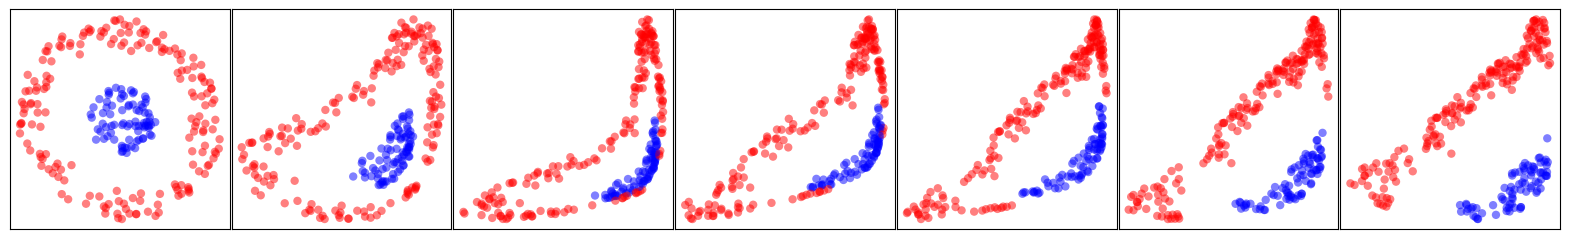

In [12]:
from viz.plots import multi_feature_plt

multi_feature_plt(feature_history[::2], targets)

#### Visualize ODE trajectories
We can also visualize how the trained model maps inputs to features.

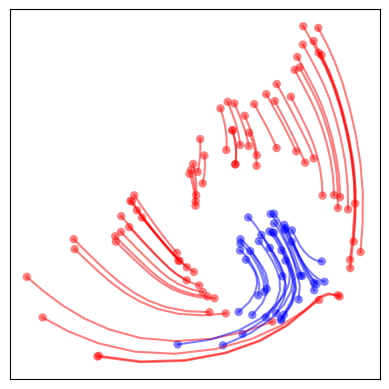

In [13]:
from viz.plots import trajectory_plt

# To make the plot clearer, we will use a smaller batch of data
for small_inputs, small_targets in dataloader:
    break

trajectory_plt(model, small_inputs, small_targets, timesteps=10)

#### Visualize generalization
To see how well the model generalizes we can plot how every point in the input space gets mapped to an output. If a point gets mapped to +1 it will be red, if it gets mapped to -1 it will be blue.

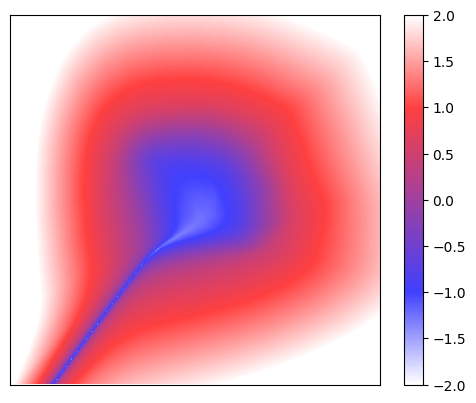

In [14]:
from viz.plots import input_space_plt

input_space_plt(model)

#### Losses and number of function evaluations

Finally we can visualize how the loss and the number of function evaluations (which is proportional to how long a forward pass takes) change during training.

Text(0, 0.5, 'Loss')

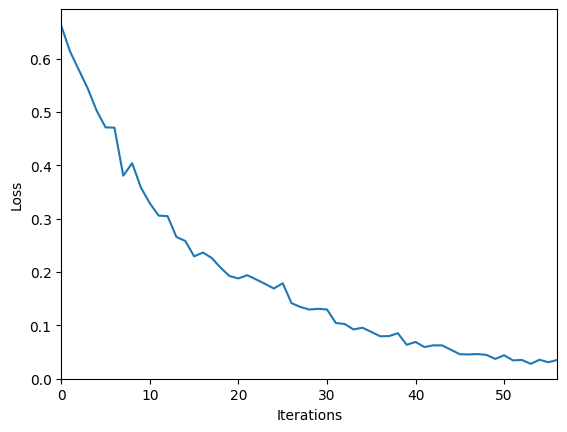

In [15]:
plt.plot(trainer.histories['loss_history'])
plt.xlim(0, len(trainer.histories['loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'NFEs')

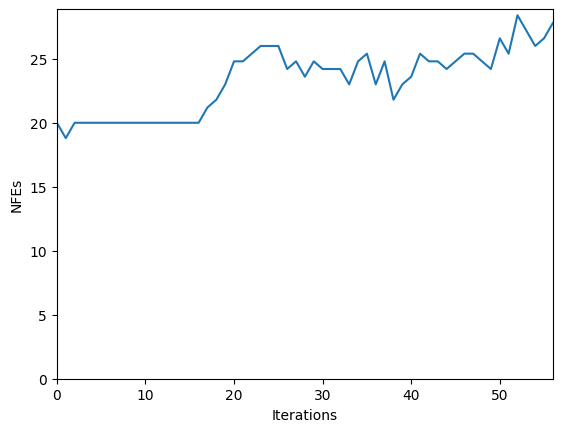

In [16]:
plt.plot(trainer.histories['nfe_history'])
plt.xlim(0, len(trainer.histories['nfe_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('NFEs')

## Train an Augmented Neural ODE

As can be seen, the Neural ODE model eventually learns to approximate the function, but does so at the cost of poor generalization and increased computational cost. We will now train an Augmented Neural ODE with one augmented dimension to attempt to mitigate these problems.

In [17]:
# Add 1 augmented dimension
anode = ODENet(device, data_dim, hidden_dim, augment_dim=1,
               time_dependent=True, non_linearity='relu')

optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3)

In [18]:
# Set up trainer
trainer_anode = Trainer(anode, optimizer_anode, device)
num_epochs = 6

# Optionally record how the features evolve during training
visualize_features = True

if visualize_features:
    feature_history = get_feature_history(trainer_anode, dataloader,
                                          inputs, targets, num_epochs)
else:
    # If we don't record feature evolution, simply train model
    trainer_anode.train(dataloader, num_epochs)


Iteration 0/47
Loss: 0.512
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 10/47
Loss: 0.497
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 20/47
Loss: 0.445
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 30/47
Loss: 0.387
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 40/47
Loss: 0.445
NFE: 20
BNFE: 0
Total NFE: 20
Epoch 1: 0.437

Iteration 0/47
Loss: 0.372
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 10/47
Loss: 0.392
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 20/47
Loss: 0.352
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 30/47
Loss: 0.275
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 40/47
Loss: 0.308
NFE: 20
BNFE: 0
Total NFE: 20
Epoch 1: 0.308

Iteration 0/47
Loss: 0.181
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 10/47
Loss: 0.143
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 20/47
Loss: 0.117
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 30/47
Loss: 0.065
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 40/47
Loss: 0.048
NFE: 20
BNFE: 0
Total NFE: 20
Epoch 1: 0.106

Iteration 0/47
Loss: 0.053
NFE: 20
BNFE: 0
Total NFE: 20

Iteration 10/4

#### Visualize feature evolution
As can be seen, the model lifts out the disk from the surrouding annulus by going into the augmented dimension.

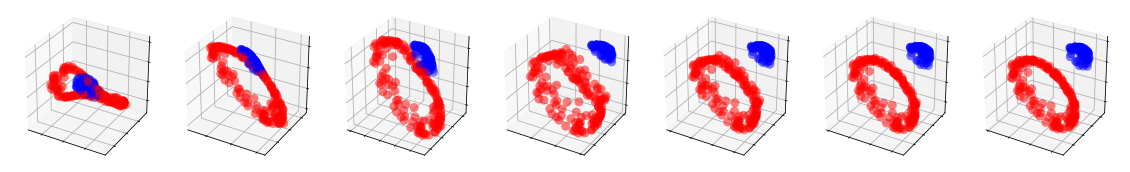

In [ ]:
from viz.plots import multi_feature_plt

multi_feature_plt(feature_history, targets)

#### Visualize ODE trajectories

We can visualize how the augmented model maps inputs to features.

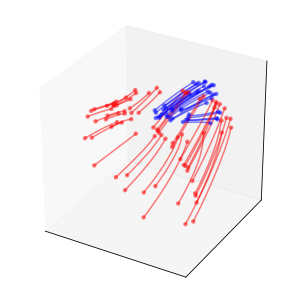

In [ ]:
from viz.plots import trajectory_plt

trajectory_plt(anode, small_inputs, small_targets, timesteps=10)

#### Visualize generalization
As can be seen, the model generalizes well and has captured the shape of the data.

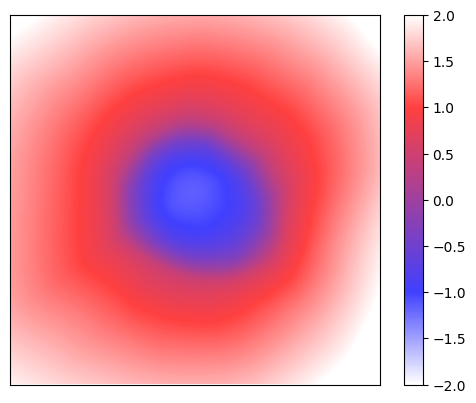

In [19]:
from viz.plots import input_space_plt

input_space_plt(anode)

#### Visualize losses and NFEs

As can be seen, the Augmented Neural ODE model achieves low losses and low NFEs. This suggests it has learned to model the data with a simple flow that is easy to compute.

Text(0, 0.5, 'Loss')

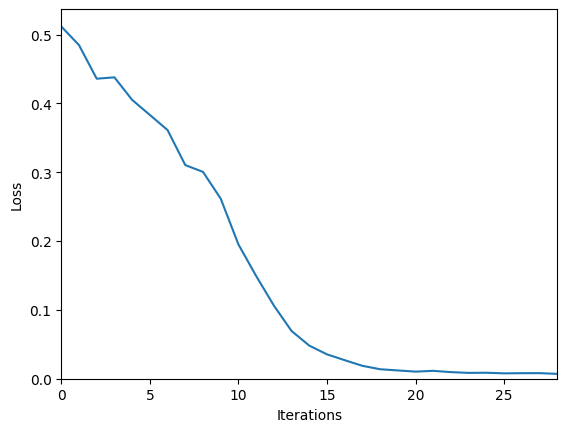

In [20]:
plt.plot(trainer_anode.histories['loss_history'])
plt.xlim(0, len(trainer_anode.histories['loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'NFEs')

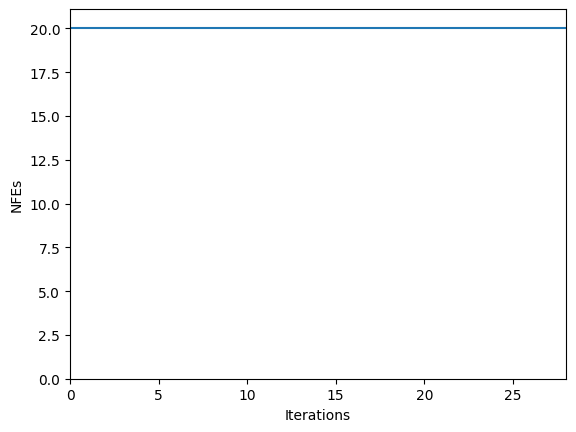

In [21]:
plt.plot(trainer_anode.histories['nfe_history'])
plt.xlim(0, len(trainer_anode.histories['nfe_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('NFEs')